In [1]:
from datascience import *
path_data = '../../../assets/data/'
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

np.set_printoptions(suppress=True)

# Multiple Regression

In [2]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

Now that we have explored ways to use multiple attributes to predict a categorical variable, let us return to predicting a quantitative variable. Predicting a numerical quantity is called regression, and a commonly used method to use multiple attributes for regression is called *multiple linear regression*.

## Home Prices

The following dataset of house prices and attributes was collected over several years for the city of Ames, Iowa. A [description of the dataset appears online](http://ww2.amstat.org/publications/jse/v19n3/decock.pdf). We will focus only a subset of the columns. We will try to predict the sale price column from the other columns.

In [3]:
all_sales = Table.read_table(path_data + 'house.csv')
sales = all_sales.where('Bldg Type', '1Fam').where('Sale Condition', 'Normal').select(
    'SalePrice', '1st Flr SF', '2nd Flr SF', 
    'Total Bsmt SF', 'Garage Area', 
    'Wood Deck SF', 'Open Porch SF', 'Lot Area', 
    'Year Built', 'Yr Sold')
sales.sort('SalePrice')

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
35000,498,0,498,216,0,0,8088,1922,2006
39300,334,0,0,0,0,0,5000,1946,2007
40000,649,668,649,250,0,54,8500,1920,2008
45000,612,0,0,308,0,0,5925,1940,2009
52000,729,0,270,0,0,0,4130,1935,2008
52500,693,0,693,0,0,20,4118,1941,2006
55000,723,363,723,400,0,24,11340,1920,2008
55000,796,0,796,0,0,0,3636,1922,2008
57625,810,0,0,280,119,24,21780,1910,2009
58500,864,0,864,200,0,0,8212,1914,2010


A histogram of sale prices shows a large amount of variability and a distribution that is clearly not normal. A long tail to the right contains a few houses that had very high prices. The short left tail does not contain any houses that sold for less than $35,000.

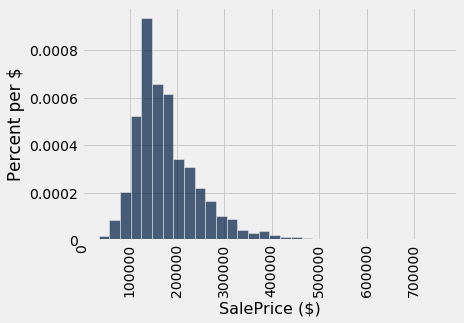

In [4]:
sales.hist('SalePrice', bins=32, unit='$')

### Correlation

No single attribute is sufficient to predict the sale price. For example, the area of first floor, measured in square feet, correlates with sale price but only explains some of its variability.

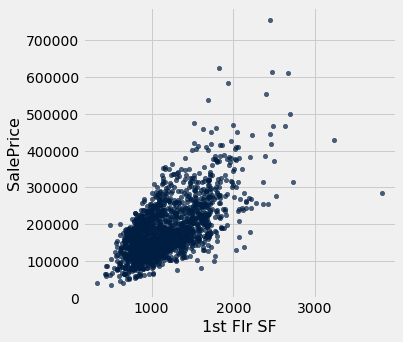

In [5]:
sales.scatter('1st Flr SF', 'SalePrice')

In [6]:
correlation(sales, 'SalePrice', '1st Flr SF')

0.6424662541030225

In fact, none of the individual attributes have a correlation with sale price that is above 0.7 (except for the sale price itself).

In [7]:
for label in sales.labels:
    print('Correlation of', label, 'and SalePrice:\t', correlation(sales, label, 'SalePrice'))

Correlation of SalePrice and SalePrice:	 1.0
Correlation of 1st Flr SF and SalePrice:	 0.6424662541030225
Correlation of 2nd Flr SF and SalePrice:	 0.3575218942800824
Correlation of Total Bsmt SF and SalePrice:	 0.652978626757169
Correlation of Garage Area and SalePrice:	 0.6385944852520443
Correlation of Wood Deck SF and SalePrice:	 0.3526986661950492
Correlation of Open Porch SF and SalePrice:	 0.3369094170263733
Correlation of Lot Area and SalePrice:	 0.2908234551157694
Correlation of Year Built and SalePrice:	 0.5651647537135916
Correlation of Yr Sold and SalePrice:	 0.02594857908072111


However, combining attributes can provide higher correlation. In particular, if we sum the first floor and second floor areas, the result has a higher correlation than any single attribute alone.

In [8]:
both_floors = sales.column(1) + sales.column(2)
correlation(sales.with_column('Both Floors', both_floors), 'SalePrice', 'Both Floors')

0.7821920556134877

This high correlation indicates that we should try to use more than one attribute to predict the sale price. In a dataset with multiple observed attributes and a single numerical value to be predicted (the sale price in this case), multiple linear regression can be an effective technique.

## Multiple Linear Regression 

In multiple linear regression, a numerical output is predicted from numerical input attributes by multiplying each attribute value by a different slope, then summing the results. In this example, the slope for the `1st Flr SF` would represent the dollars per square foot of area on the first floor of the house that should be used in our prediction. 

Before we begin prediction, we split our data randomly into a training and test set of equal size.

In [9]:
train, test = sales.split(1001)
print(train.num_rows, 'training and', test.num_rows, 'test instances.')

1001 training and 1001 test instances.


The slopes in multiple regression is an array that has one slope value for each attribute in an example. Predicting the sale price involves multiplying each attribute by the slope and summing the result.

In [10]:
def predict(slopes, row):
    return sum(slopes * np.array(row))

example_row = test.drop('SalePrice').row(0)
print('Predicting sale price for:', example_row)
example_slopes = np.random.normal(10, 1, len(example_row))
print('Using slopes:', example_slopes)
print('Result:', predict(example_slopes, example_row))

Predicting sale price for: Row(1st Flr SF=1207, 2nd Flr SF=0, Total Bsmt SF=1135.0, Garage Area=264.0, Wood Deck SF=0, Open Porch SF=240, Lot Area=9510, Year Built=1962, Yr Sold=2006)
Using slopes: [ 9.52065867  8.58939769 11.48702417  9.50389131  9.09151019  9.86944284
 10.71929443 10.88966608  8.33339346]
Result: 169429.7032316262


The result is an estimated sale price, which can be compared to the actual sale price to assess whether the slopes provide accurate predictions. Since the `example_slopes` above were chosen at random, we should not expect them to provide accurate predictions at all.

In [11]:
print('Actual sale price:', test.column('SalePrice').item(0))
print('Predicted sale price using random slopes:', predict(example_slopes, example_row))

Actual sale price: 147000
Predicted sale price using random slopes: 169429.7032316262


### Least Squares Regression

The next step in performing multiple regression is to define the least squares objective. We perform the prediction for each row in the training set, and then compute the root mean squared error (RMSE) of the predictions from the actual prices.

In [12]:
train_prices = train.column(0)
train_attributes = train.drop(0)

def rmse(slopes, attributes, prices):
    errors = []
    for i in np.arange(len(prices)):
        predicted = predict(slopes, attributes.row(i))
        actual = prices.item(i)
        errors.append((predicted - actual) ** 2)
    return np.mean(errors) ** 0.5

def rmse_train(slopes):
    return rmse(slopes, train_attributes, train_prices)

print('RMSE of all training examples using random slopes:', rmse_train(example_slopes))

RMSE of all training examples using random slopes: 68153.56796456952


Finally, we use the `minimize` function to find the slopes with the lowest RMSE. Since the function we want to minimize, `rmse_train`, takes an array instead of a number, we must pass the `array=True` argument to `minimize`. When this argument is used, `minimize` also requires an initial guess of the slopes so that it knows the dimension of the input array. Finally, to speed up optimization, we indicate that `rmse_train` is a smooth function using the `smooth=True` attribute. Computation of the best slopes may take several minutes.

In [13]:
best_slopes = minimize(rmse_train, start=example_slopes, smooth=True, array=True)
print('The best slopes for the training set:')
Table(train_attributes.labels).with_row(list(best_slopes)).show()
print('RMSE of all training examples using the best slopes:', rmse_train(best_slopes))

The best slopes for the training set:


1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
68.7068,74.3857,56.0494,36.1706,26.4397,21.4779,0.558904,534.101,-528.216


RMSE of all training examples using the best slopes: 29311.117940347867


### Interpreting Multiple Regression 

Let's interpret these results. The best slopes give us a method for estimating the price of a house from its attributes. A square foot of area on the first floor is worth about \$75 (the first slope), while one on the second floor is worth about \$70 (the second slope). The final negative value describes the market: prices in later years were lower on average.

The RMSE of around \$30,000 means that our best linear prediction of the sale price based on all of the attributes is off by around \$30,000 on the training set, on average.  We find a similar error when predicting prices on the test set, which indicates that our prediction method will generalize to other samples from the same population.

In [14]:
test_prices = test.column(0)
test_attributes = test.drop(0)

def rmse_test(slopes):
    return rmse(slopes, test_attributes, test_prices)

rmse_linear = rmse_test(best_slopes)
print('Test set RMSE for multiple linear regression:', rmse_linear)

Test set RMSE for multiple linear regression: 33025.064938240575


If the predictions were perfect, then a scatter plot of the predicted and actual values would be a straight line with slope 1. We see that most dots fall near that line, but there is some error in the predictions.

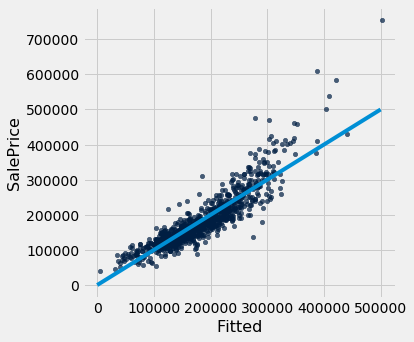

In [15]:
def fit(row):
    return sum(best_slopes * np.array(row))

test.with_column('Fitted', test.drop(0).apply(fit)).scatter('Fitted', 0)
plots.plot([0, 5e5], [0, 5e5]);

A residual plot for multiple regression typically compares the errors (residuals) to the actual values of the predicted variable. We see in the residual plot below that we have systematically underestimated the value of expensive houses, shown by the many positive residual values on the right side of the graph.

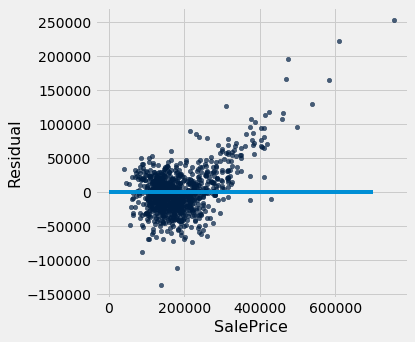

In [16]:
test.with_column('Residual', test_prices-test.drop(0).apply(fit)).scatter(0, 'Residual')
plots.plot([0, 7e5], [0, 0]);

As with simple linear regression, interpreting the result of a predictor is at least as important as making predictions. There are many lessons about interpreting multiple regression that are not included in this textbook. A natural next step after completing this text would be to study linear modeling and regression in further depth.

## Nearest Neighbors for Regression

Another approach to predicting the sale price of a house is to use the price of similar houses. This *nearest neighbor* approach is very similar to our classifier. To speed up computation, we will only use the attributes that had the highest correlation with the sale price in our original analysis.

In [17]:
train_nn = train.select(0, 1, 2, 3, 4, 8)
test_nn = test.select(0, 1, 2, 3, 4, 8)
train_nn.show(3)

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built
270000,1673,0,1673,583,2000
158000,986,537,1067,295,1949
249000,1506,0,1494,672,2005


The computation of closest neighbors is identical to a nearest-neighbor classifier. In this case, we will exclude the `'SalePrice'` rather than the `'Class'` column from the distance computation. The five nearest neighbors of the first test row are shown below.

In [18]:
def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(row1), np.array(row2))

def distances(training, example, output):
    """Compute the distance from example for each row in training."""
    dists = []
    attributes = training.drop(output)
    for row in attributes.rows:
        dists.append(row_distance(row, example))
    return training.with_column('Distance', dists)

def closest(training, example, k, output):
    """Return a table of the k closest neighbors to example."""
    return distances(training, example, output).sort('Distance').take(np.arange(k))

example_nn_row = test_nn.drop(0).row(0)
closest(train_nn, example_nn_row, 5, 'SalePrice')

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built,Distance
137000,1176,0,1158,303,1958,55.0182
146000,1150,0,1150,288,1961,63.6475
126175,1163,0,1162,220,1955,68.1909
157900,1188,0,1188,312,1962,73.9865
150000,1144,0,1169,286,1956,75.1332


One simple method for predicting the price is to average the prices of the nearest neighbors.

In [19]:
def predict_nn(example):
    """Return the majority class among the k nearest neighbors."""
    return np.average(closest(train_nn, example, 5, 'SalePrice').column('SalePrice'))

predict_nn(example_nn_row)

143415.0

Finally, we can inspect whether our prediction is close to the true sale price for our one test example. Looks reasonable!

In [20]:
print('Actual sale price:', test_nn.column('SalePrice').item(0))
print('Predicted sale price using nearest neighbors:', predict_nn(example_nn_row))

Actual sale price: 147000
Predicted sale price using nearest neighbors: 143415.0


### Evaluation

To evaluate the performance of this approach for the whole test set, we apply `predict_nn` to each test example, then compute the root mean squared error of the predictions. Computation of the predictions may take several minutes.

In [21]:
nn_test_predictions = test_nn.drop('SalePrice').apply(predict_nn)
rmse_nn = np.mean((test_prices - nn_test_predictions) ** 2) ** 0.5

print('Test set RMSE for multiple linear regression: ', rmse_linear)
print('Test set RMSE for nearest neighbor regression:', rmse_nn)

Test set RMSE for multiple linear regression:  33025.064938240575
Test set RMSE for nearest neighbor regression: 36067.116043510105


For these data, the errors of the two techniques are quite similar! For different data sets, one technique might outperform another. By computing the RMSE of both techniques on the same data, we can compare methods fairly. One note of caution: the difference in performance might not be due to the technique at all; it might be due to the random variation due to sampling the training and test sets in the first place.

Finally, we can draw a residual plot for these predictions. We still underestimate the prices of the most expensive houses, but the bias does not appear to be as systematic. However, fewer residuals are very close to zero, indicating that fewer prices were predicted with very high accuracy. 

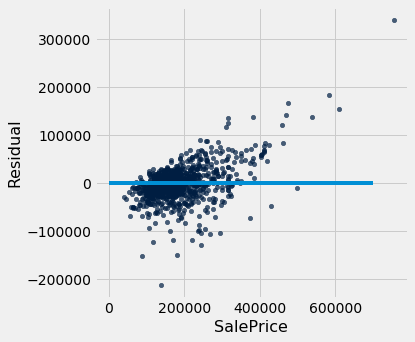

In [22]:
test.with_column('Residual', test_prices-nn_test_predictions).scatter(0, 'Residual')
plots.plot([0, 7e5], [0, 0]);